In [9]:
import torchvision.datasets as datasets

dataset = datasets.ImageFolder(root="/kaggle/input/indian-folk-art-gallery-high-resolution-images/folk-art-dataset-main")
print(dataset.class_to_idx)

{'Aipan Art (Uttarakhand)': 0, 'Assamese Miniature Painting (Assam)': 1, 'Basholi Painting (Jammu and Kashmir)': 2, 'Bhil Painting (Madhya Pradesh)': 3, 'Chamba Rumal (Himachal Pradesh)': 4, 'Cheriyal Scroll Painting (Telangana)': 5, 'Dokra Art(West Bengal)': 6, 'Gond Painting (Madhya Pradesh)': 7, 'Kalamkari Painting (Andra Pradesh and Telangana)': 8, 'Kalighat Painting (West Bengal)': 9, 'Kangra Painting (Himachal Pradesh)': 10, 'Kerala Mural Painting (Kerala)': 11, 'Kondapalli Bommallu (Andra Pradesh)': 12, 'Kutch Lippan Art (Gujarat)': 13, 'Leather Puppet Art (Andra Pradesh)': 14, 'Madhubani Painting (Bihar)': 15, 'Mandala Art': 16, 'Mandana Art (Rajasthan)': 17, 'Mata Ni Pachedi (Gujarat)': 18, 'Meenakari Painting (Rajasthan)': 19, 'Mughal Paintings': 20, 'Mysore Ganjifa Art (Karnataka)': 21, 'Pattachitra Painting (Odisha and Bengal)': 22, 'Patua Painting (West Bengal)': 23, 'Pichwai Painting (Rajasthan)': 24, 'Rajasthani Miniature Painting (Rajasthan)': 25, 'Rogan Art from Kutch 

In [10]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import numpy as np


# 1. Custom transform to add Gaussian noise
class GaussianNoise(object):
    """
    Adds Gaussian noise to a tensor.
    """
    def __init__(self, mean=0.0, std=0.01):
        """
        :param mean: Mean of the Gaussian noise
        :param std: Standard deviation of the Gaussian noise
        """
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # tensor is assumed to be a PyTorch tensor with shape [C, H, W]
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"


def create_dataloaders(dataset_dir, batch_size=32, num_workers=2):
    """
    Creates PyTorch dataloaders for train and test sets with 80-20 split,
    applies data augmentation & normalization for the train subset, and
    minimal transforms (resize & normalize) for the test subset.
    
    :param dataset_dir:  Path to the root directory of your dataset (ImageFolder style).
    :param batch_size:   Batch size for train/test loaders.
    :param num_workers:  Number of worker processes for data loading.
    :return:             (train_loader, test_loader)
    """

    # 2. Define data augmentation transforms for the training set
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        ),
        transforms.ToTensor(),
        GaussianNoise(mean=0.0, std=0.01),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    # 3. Define transforms for the test set (resize & normalize only)
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    # 4. Create a base dataset without any transform
    full_dataset = datasets.ImageFolder(root=dataset_dir, transform=None)

    # 5. Split into train (80%) and test (20%)
    dataset_size = len(full_dataset)
    train_size = int(0.8 * dataset_size)
    test_size = dataset_size - train_size
    
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # 6. Assign transforms to each subset
    train_dataset.dataset.transform = train_transforms
    test_dataset.dataset.transform = test_transforms

    # 7. Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    
    return train_loader, test_loader


if __name__ == "__main__":
    # Replace 'path/to/your/dataset' with your dataset folder in ImageFolder style
    dataset_directory = "/kaggle/input/indian-folk-art-gallery-high-resolution-images/folk-art-dataset-main"
    
    train_loader, test_loader = create_dataloaders(
        dataset_dir=dataset_directory,
        batch_size=32,
        num_workers=2
    )
    
    # Example usage: just check the first batch
    for images, labels in train_loader:
        print(f"Train batch images shape: {images.shape}")
        print(f"Train batch labels shape: {labels.shape}")
        break
    
    for images, labels in test_loader:
        print(f"Test batch images shape: {images.shape}")
        print(f"Test batch labels shape: {labels.shape}")
        break


Train batch images shape: torch.Size([32, 3, 224, 224])
Train batch labels shape: torch.Size([32])
Test batch images shape: torch.Size([32, 3, 224, 224])
Test batch labels shape: torch.Size([32])


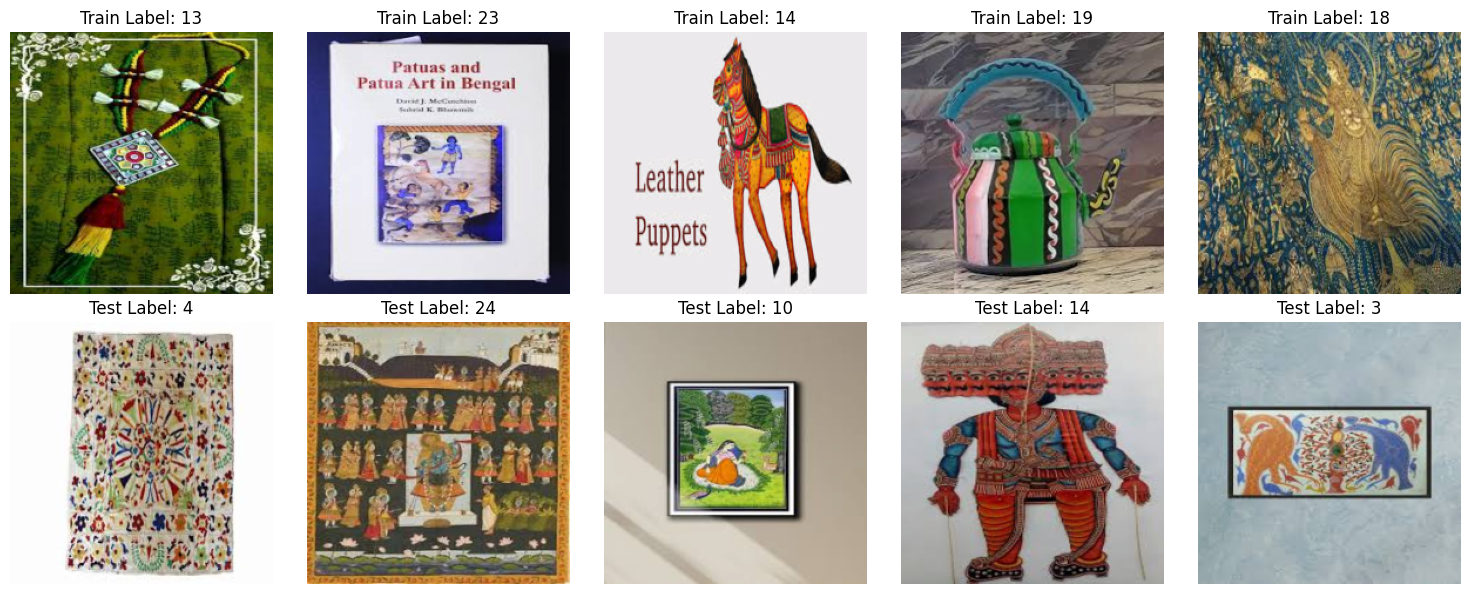

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# If you used ImageNet normalization:
# mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]

def unnormalize_image(tensor, mean, std):
    """
    Unnormalizes a single image tensor of shape [C, H, W].
    mean and std are lists of length C (3 for RGB).
    """
    # Convert to numpy for easier manipulation
    image = tensor.permute(1, 2, 0).cpu().numpy()  # Shape: [H, W, C]

    # Unnormalize: image = (image * std) + mean
    image = (image * std) + mean
    image = np.clip(image, 0, 1)  # Clip values to [0, 1] range for plotting
    
    return image

def plot_train_and_test_examples(train_loader, test_loader):
    # Retrieve one batch from each loader
    train_images, train_labels = next(iter(train_loader))
    test_images, test_labels = next(iter(test_loader))

    # Number of examples to show
    num_examples = 5

    # You can adjust these if you used something other than ImageNet stats
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std  = np.array([0.229, 0.224, 0.225])

    fig, axes = plt.subplots(nrows=2, ncols=num_examples, figsize=(15, 6))

    # Plot 5 training images
    for i in range(num_examples):
        ax = axes[0, i]
        # Unnormalize
        img_unnorm = unnormalize_image(train_images[i], imagenet_mean, imagenet_std)
        label = train_labels[i].item()  # or train_labels[i] if it's an int
        ax.imshow(img_unnorm)
        ax.set_title(f"Train Label: {label}")
        ax.axis("off")

    # Plot 5 test images
    for i in range(num_examples):
        ax = axes[1, i]
        # Unnormalize
        img_unnorm = unnormalize_image(test_images[i], imagenet_mean, imagenet_std)
        label = test_labels[i].item()
        ax.imshow(img_unnorm)
        ax.set_title(f"Test Label: {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_train_and_test_examples(train_loader, test_loader)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def train_resnet18(train_loader, test_loader, num_classes, num_epochs=10, lr=1e-3, device=None):
    """
    Trains a pretrained ResNet18 model for a multiclass classification task.
    Uses train_loader for training and test_loader for validation.
    
    :param train_loader: PyTorch DataLoader for the training set
    :param test_loader:  PyTorch DataLoader for the test/validation set
    :param num_classes:  Number of output classes
    :param num_epochs:   Number of epochs to train
    :param lr:           Learning rate
    :param device:       Device to use ('cuda' or 'cpu')
    :return:             Trained model
    """
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Load Pretrained ResNet18
    model = models.resnet18(pretrained=True)
    
    # 2. Modify final fully-connected layer to match num_classes
    #    ResNet18's final layer is model.fc
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    model = model.to(device)
    
    # 3. Define Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # (Optional) If you want to freeze all layers except the final FC layer:
    # for param in model.parameters():
    #     param.requires_grad = False
    # for param in model.fc.parameters():
    #     param.requires_grad = True
    # 
    # Then the optimizer should only optimize model.fc.parameters():
    # optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    
    # 4. Training Loop
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        ########################################
        #            TRAINING PHASE
        ########################################
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update training stats
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
        
        train_loss = running_loss / total_samples
        train_accuracy = correct_predictions / total_samples
        
        ########################################
        #           VALIDATION PHASE
        ########################################
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        
        # Print stats each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}   | Val Acc: {val_accuracy:.4f}")
        
        # Track best model using validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_resnet18.pth")
    
    print("Training complete.")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    return model


if __name__ == "__main__":
    # Example usage (assuming you've created train_loader and test_loader):
    # num_classes should match the number of classes in your dataset
    num_classes = 30
    
    
    model = train_resnet18(
        train_loader=train_loader,
        test_loader=test_loader,
        num_classes=num_classes,
        num_epochs=50,  # Feel free to adjust
        lr=1e-3
    )

    # Now 'model' is trained; you can use it for inference or further fine-tuning.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s] 
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/

Epoch [1/50] Train Loss: 1.6938 | Train Acc: 0.5220 | Val Loss: 1.6852   | Val Acc: 0.5495


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/50] Train Loss: 1.1085 | Train Acc: 0.6778 | Val Loss: 1.1292   | Val Acc: 0.6872


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/50] Train Loss: 0.7998 | Train Acc: 0.7640 | Val Loss: 1.1100   | Val Acc: 0.7009


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/50] Train Loss: 0.5666 | Train Acc: 0.8307 | Val Loss: 0.8340   | Val Acc: 0.7724


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/50] Train Loss: 0.4265 | Train Acc: 0.8726 | Val Loss: 0.8142   | Val Acc: 0.7880


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/50] Train Loss: 0.3193 | Train Acc: 0.9044 | Val Loss: 0.8934   | Val Acc: 0.7838


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/50] Train Loss: 0.2579 | Train Acc: 0.9218 | Val Loss: 0.8417   | Val Acc: 0.8056


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/50] Train Loss: 0.2177 | Train Acc: 0.9355 | Val Loss: 0.8931   | Val Acc: 0.8083


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/50] Train Loss: 0.1851 | Train Acc: 0.9464 | Val Loss: 1.0106   | Val Acc: 0.7925


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/50] Train Loss: 0.1773 | Train Acc: 0.9459 | Val Loss: 1.0018   | Val Acc: 0.7902


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/50] Train Loss: 0.1530 | Train Acc: 0.9523 | Val Loss: 0.9363   | Val Acc: 0.8202


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12/50] Train Loss: 0.1579 | Train Acc: 0.9520 | Val Loss: 0.9195   | Val Acc: 0.8236


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13/50] Train Loss: 0.1203 | Train Acc: 0.9618 | Val Loss: 0.9950   | Val Acc: 0.8205


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/50] Train Loss: 0.1210 | Train Acc: 0.9600 | Val Loss: 1.0224   | Val Acc: 0.8115


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/50] Train Loss: 0.1260 | Train Acc: 0.9590 | Val Loss: 0.9599   | Val Acc: 0.8262


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [16/50] Train Loss: 0.1106 | Train Acc: 0.9648 | Val Loss: 1.0836   | Val Acc: 0.8128


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [17/50] Train Loss: 0.1005 | Train Acc: 0.9659 | Val Loss: 1.0441   | Val Acc: 0.8128


KeyboardInterrupt: 

In [16]:
import torch
import numpy as np

def predict_with_logits(model, image_tensor, device=None):
    """
    Given a model and a single preprocessed image tensor, 
    returns the predicted label, the logits, and the class probabilities.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Add batch dimension: [1, C, H, W]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        # 1) Forward pass to get the raw logits
        logits = model(image_tensor)  # shape: [1, num_classes]
        
        # 2) Convert logits to numpy (removing batch dimension)
        logits_np = logits.squeeze(0).cpu().numpy()  # shape: [num_classes]
        
        # 3) Compute probabilities via softmax
        probabilities = torch.softmax(logits, dim=1)  # shape: [1, num_classes]
        probabilities_np = probabilities.squeeze(0).cpu().numpy()  # shape: [num_classes]
        
        # 4) Predicted class index is the one with the highest logit
        predicted_label_idx = np.argmax(logits_np)
    
    # Print the raw logits (BEFORE softmax)
    print("\nRaw Logits (before softmax):")
    for i, val in enumerate(logits_np):
        print(f"Class {i}: {val:.4f}")
    
    # Print the softmax probabilities
    print("\nSoftmax Probabilities:")
    for i, val in enumerate(probabilities_np):
        print(f"Class {i}: {val:.4f}")
    
    print(f"\nPredicted Label Index: {predicted_label_idx}")
    
    return predicted_label_idx, logits_np, probabilities_np


# Example usage:
if __name__ == "__main__":
    # Assume 'model' is your trained ResNet-18 (or any other model) 
    # and 'image_tensor' is a single preprocessed image.
    weights_path = "/kaggle/working/best_resnet18.pth"  # Replace with your .pth file
    model = load_model(weights_path, num_classes=30, device=device)
    
    # 2. Preprocess the image
    test_image_path = "/kaggle/input/indian-folk-art-gallery-high-resolution-images/folk-art-dataset-main/Dokra Art(West Bengal)/10.jpg"  # Replace with an actual image
    image_tensor = preprocess_image(test_image_path)
    predicted_idx, logits, probs = predict_with_logits(model, image_tensor, device=device)



Raw Logits (before softmax):
Class 0: -30.4619
Class 1: -21.3962
Class 2: -14.6622
Class 3: -14.4291
Class 4: -19.7263
Class 5: -17.3813
Class 6: 28.3015
Class 7: -13.7982
Class 8: -16.3285
Class 9: -16.9902
Class 10: -20.6740
Class 11: -5.4228
Class 12: -4.2623
Class 13: -19.8643
Class 14: -13.6468
Class 15: -21.5092
Class 16: -19.6640
Class 17: -19.6771
Class 18: -14.3439
Class 19: -18.7868
Class 20: -12.1058
Class 21: -18.8095
Class 22: -14.1839
Class 23: -24.4168
Class 24: -16.3812
Class 25: -12.6068
Class 26: -16.2895
Class 27: -24.0983
Class 28: -17.4895
Class 29: -9.6447

Softmax Probabilities:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 1.0000
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000
Class 10: 0.0000
Class 11: 0.0000
Class 12: 0.0000
Class 13: 0.0000
Class 14: 0.0000
Class 15: 0.0000
Class 16: 0.0000
Class 17: 0.0000
Class 18: 0.0000
Class 19: 0.0000
Class 20: 0.0000
Class 21: 0.0000
Class 22: 0.0000
Class 23:

<ipython-input-15-6d6967718893>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))
